<ins>**Contexte**</ins> :Stack Overflow est un site célèbre de questions-réponses liées au développement informatique.



Pour poser une question sur ce site, il faut entrer plusieurs tags afin de retrouver facilement la question par la suite. Pour les utilisateurs expérimentés, cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Pour aider la communauté dans sa recherche de tags pertinents lors de la conception des questions nous allons développer un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

<ins>**Import des bibliothèques**</ins>

In [268]:
# Manipualtion des données
import pandas as pd

# Représentation graphique
import matplotlib.pyplot as plt
import seaborn as sns

# Netooyage du texte
import re
from bs4 import BeautifulSoup

# NLP
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize


# Cacher les warnings 
import warnings
warnings.simplefilter("ignore")

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [269]:
#Import des données 
global data
data= pd.read_csv('QueryResults.csv')
data.head(5)

,Title,Body,Tags,Id
0,Is Java ArrayList / String / atomic variable r...,<p>I've been mulling this over &amp; reading b...,<java><synchronization><multithreading><arrayl...,2388808
1,GET vs. POST Best Practices,"<p>For my web application (PHP/MYSQL), I show ...",<php><html><http><forms><rest>,679013
2,How to mock a Kotlin singleton object?,<p>Given a Kotlin singleton object and a fun t...,<mocking><mockito><kotlin><powermock><powermoc...,37977320
3,Error when dismissing view controller,<p>Getting an error when dismissing a view con...,<ios><objective-c><xcode><uiviewcontroller>,20021107
4,Google Maps: How to create a custom InfoWindow?,<p>The default Google Maps InfoWindow for a ma...,<javascript><html><css><google-maps>,3860277


In [270]:
data.tail(5)

,Title,Body,Tags,Id
49995,How do I prevent exposure of my password when ...,"<p>I love <a href=""http://www.omegahat.org/RGo...",<r><passwords><google-docs><rstudio>,6101605
49996,What is the native keyword in Java for?,"<p>While playing <a href=""http://www.sporcle.c...",<java><java-native-interface><native><keyword>,6101311
49997,How to enable CORS in AngularJs,<p>I have created a demo using JavaScript for ...,<javascript><angularjs><xmlhttprequest><cors>,23823010
49998,Family Tree Algorithm,<p>I'm working on putting together a problem s...,<algorithm><graph><tree><family-tree>,6102125
49999,Ionic Serve Live Reload Not Working,<p>I just bought a new MacBook and installed i...,<google-chrome><ionic-framework><reload><live>...,42219946


In [271]:
data.sample(20)

,Title,Body,Tags,Id
31173,setBackground vs setBackgroundDrawable (Android),<p>I want to set background drawable of a view...,<android><view><background><drawable>,11947603
9615,"""Thorough"", tutorial on setting up Jetbrain's ...",<p>Does anyone know where I can find a good tu...,<.net><nunit><continuous-integration><teamcity>,361386
3647,Html to pdf some characters are missing (itext...,<p>I want to export gridview to pdf by using t...,<c#><.net><asp.net><pdf-generation><itext>,1322303
35075,"Eclipse ""cannot find the tag library descripto...",<p>I have a Java EE project which build fine w...,<java><eclipse><jsp><taglib><custom-tags>,1265309
43167,"C++, how to declare a struct in a header file",<p>I've been trying to include a structure cal...,<c++><struct><include><header><header-files>,2732978
36502,Implementing Unit Testing with iOS,"<p>I've followed <a href=""http://developer.app...",<ios><xcode><unit-testing><ios-simulator>,2002330
28984,How to get coefficients and their confidence i...,<p>In <code>lm</code> and <code>glm</code> mod...,<r><lme4><random-effects><mixed-models>,11072544
6661,What's the difference between synchronous and ...,<p>For the longest time I thought asynchronous...,<ios><objective-c><multithreading><asynchronou...,21122842
23971,Excel error HRESULT: 0x800A03EC while trying t...,<p>I am working with Window Service project. t...,<c#><excel><exception><vsto>,891394
35871,What is DOM Event delegation?,<p>Can anyone please explain event delegation ...,<javascript><event-handling><dom-events><event...,1687296


In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
 3   Id      50000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


Un dataset de 50000 ligne et 4 colonnes.

<ins>**Recherche de doublons** </ins>

In [273]:
data.duplicated(subset='Title').sum()

5

In [274]:
data.duplicated(subset=['Body']).sum()

0

In [275]:
data.duplicated(subset=['Tags']).sum()

1762

Existe-t-il une question qui a été postée 2 fois par le même auteur ? 

In [276]:
data.duplicated(subset=['Body','Tags']).sum()

0

<ins>**Recherche de valeurs manquantes**</ins>

In [277]:
#Valeurs manquantes
data.isnull().sum()

Title    0
Body     0
Tags     0
Id       0
dtype: int64

Il n'y a pas de valeurs manquantes dans notre jeu de données.

<ins> **Preprocessing des données** </ins>

Le preprocessing comporte plusieurs étapes souvent complémentaires. Nous allons ici découvrir les plus courantes, à savoir :

- Normalisation du texte et nettoyage
- Tokénization
- Suppression des stopwords
- Lemmatization (ou Stemming)
- N-grams

<ins>Normalisation et nettoyage </ins>

Normaliser le texte signifie le mettre à la même casse, souvent tout en minuscule.



In [278]:
def normalise_and_clean(list_words):
    """
    Normalise et nettoie une liste de mots.
    Args:
        list_words (list): Une liste de mots.
    Returns:
        str: La chaîne nettoyée.
    """
    # Convertir en minuscules
    lw = list_words.lower()

    #Conservation des mots c# et c++
    lw =lw.replace('c#','csharpxxx').replace('c++','cplusxxx').replace('c #','csharpxxx').replace('c ++','cplusxxx')

    # Supprimer les balises HTML
    lw = BeautifulSoup(lw, "html.parser").get_text()
    

    # Supprimer les nombres
    lw = re.sub(r'\w*\d+\w*', ' ', lw)

    # Supprimer les espaces inutiles
    lw = re.sub('\s+', ' ', lw)

    # Supprimer les contractions en anglais
    lw = re.sub("\'\w+", ' ', lw)

    # Supprimer les URL
    lw = re.sub(r'http*\S+', ' ', lw)
    lw = re.sub(r'www*\S+', ' ', lw)

    # Dernier nettoyage: supprimer les tirets, les signes plus et les barres obliques
    #lw_clean = lw.replace('-', ' ').replace('/', ' ').replace('___',' ').replace('^',' ').replace('c#','csharpxxx').replace('c++','cplusxxx')
    #lw_clean = lw_clean.replace('[', ' ').replace(']', ' ').replace(',', ' ').replace('|',' ').replace('.',' ').replace('c #','csharp').replace('c ++','cplus')
    #lw_clean = lw_clean.replace(':', ' ').replace('?', ' ').replace('(', ' ').replace(')', ' ').replace('=','').replace('_',' ').replace("\\","")

    #Suprression de tous les caractères spéciaux 
    lw_clean= re.sub(r'[^\w\s]',' ', lw)

    return lw_clean


In [279]:
def normalise_and_clean1(liste_mots):
    """
    Normalise et nettoie le texte de la liste de mots fournie.
    :param liste_mots: la liste de mots à normaliser et nettoyer
    :return: le texte nettoyé et normalisé
    """
    from bs4 import BeautifulSoup
    import re
    # Convertir le texte en minuscules
    texte = liste_mots.lower()

    #Conservation des mots c# et c++
    texte =texte.replace('c#','csharpxxx').replace('c #','csharpxxx').replace('c ++','cplusxxx').replace('c++','cplusxxx')

    # BeautifulSoup pour supprimer les balises HTML et les entités
    texte = BeautifulSoup(texte, "lxml").get_text()

    # Expression régulière pour supprimer les URLs, les caractères non-alphanumériques
    # et les nombres qui apparaissent au début ou à la fin d'un mot
    texte_nettoye = re.sub(r"[^a-zA-Z\s]+|(http\S+)|(www\.\S+)|\d+", ' ', texte)

    return texte_nettoye


<ins>Tokénization </ins>

In [280]:
# Tokenizer

def tokenizer_fct(sentence) :
    #Tokenisation = réduction des phrases en mots élémentaires  
    word_tokens = word_tokenize(sentence)
    return  word_tokens 

<ins> stop words</ins>

In [281]:
# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english')))

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

<ins> Lemmatization / stemming </ins>

In [282]:
# Lemmatizer (base d'un mot)
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(list_words)
    lem_w = [lemmatizer.lemmatize(word, pos=wordnet_map.get(pos[0].upper(), wordnet.NOUN)) for word, pos in pos_tags]
    return lem_w

# Mapping POS tags to WordNet POS tags
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}

# Tetser le stemming aussi 

<ins> Réintégration des mots c# et c++ </ins>

In [283]:
def c_sharp_pp(words_list):
    for i in range(len(words_list)):
            if "sharpxxx" or "cplusxxx" in words_list[i]:
                words_list[i] = words_list[i].replace("sharpxxx", "#")
                words_list[i] = words_list[i].replace("plusxxx", "++")
    return words_list

<ins> Fonction globale de processing (ragroupant toutes les fonctions créées supra) </ins>

In [284]:
import spacy

def preprocessing(texte, rejoin=True):
    def normalise_and_clean1(liste_mots):
        """
        Normalise et nettoie le texte de la liste de mots fournie.
        :param liste_mots: la liste de mots à normaliser et nettoyer
        :return: le texte nettoyé et normalisé
        """
        from bs4 import BeautifulSoup
        import re
        # Convertir le texte en minuscules
        texte = liste_mots.lower()

        #Conservation des mots c# et c++
        texte =texte.replace('c#','csharpxxx').replace('c #','csharpxxx').replace('c ++','cplusxxx').replace('c++','cplusxxx')

        # BeautifulSoup pour supprimer les balises HTML et les entités
        texte = BeautifulSoup(texte, "lxml").get_text()

        # Expression régulière pour supprimer les URLs, les caractères non-alphanumériques
        # et les nombres qui apparaissent au début ou à la fin d'un mot
        texte_nettoye = re.sub(r"[^a-zA-Z\s]+|(http\S+)|(www\.\S+)|\d+", ' ', texte)

        return texte_nettoye
    
    from nltk.tokenize import sent_tokenize, word_tokenize
    def tokenizer_fct(sentence) :
        #Tokenisation = réduction des phrases en mots élémentaires  
        word_tokens = word_tokenize(sentence)
        return  word_tokens 
    

    from nltk.corpus import stopwords
    stop_w = list(set(stopwords.words('english')))

    def stop_word_filter_fct(list_words) :
        filtered_w = [w for w in list_words if not w in stop_w]
        filtered_w2 = [w for w in filtered_w if len(w) > 2]
        return filtered_w2
    
    
    def c_sharp_pp(words_list):
        for i in range(len(words_list)):
                if "sharpxxx" or "cplusxxx" in words_list[i]:
                    words_list[i] = words_list[i].replace("sharpxxx", "#")
                    words_list[i] = words_list[i].replace("plusxxx", "++")
        return words_list
    


    import nltk
    from nltk.corpus import wordnet
    from nltk.stem import WordNetLemmatizer
    # Lemmatizer (base d'un mot)
    def lemma_fct(list_words):
        lemmatizer = WordNetLemmatizer()
        pos_tags = nltk.pos_tag(list_words)
        lem_w = [lemmatizer.lemmatize(word, pos=wordnet_map.get(pos[0].upper(), wordnet.NOUN)) for word, pos in pos_tags]
        return lem_w

    # Mapping POS tags to WordNet POS tags
    wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}
        

    #Normalise et cleaning
    texte=normalise_and_clean1(texte)
    #Tokenasiation
    texte=tokenizer_fct(texte)
    #Stops words
    texte=stop_word_filter_fct(texte)
    #Réintégration des mots c# et c++ dans le corpus de texte
    texte=c_sharp_pp(texte)
    #Lemmatisation
    texte=lemma_fct(texte)
    #Conversion du texte en str
    
    
    if rejoin :
        # On renvoie une chaîne de caractère (en combinant tous les mots texte)
        return ' '.join(texte)
    return texte

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

# df.apply(func)


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [285]:
#Construction du document
data['document']= data.apply(lambda x : x['Title']+' '+x['Body'], axis=1)

In [287]:
#This function will remove the unecessary part of speech and keep only necessary part of speech given by pos_list
def remove_verb_and_adj1 (texte):
    doc = texte
    pos_list = ["NOUN","PROPN"]
    text_list = []
    for token in doc:
            if(token.pos_ in pos_list):
                 text_list.append(token.text)
    join_text = " ".join(text_list)
    join_text = join_text.lower().replace("c #", "c#")

    return join_text

In [288]:
nlp = spacy.load("en_core_web_sm") 
data['Body_cleaned']=data.Body.parallel_apply(preprocessing)
data['Title_cleaned'] = data.Title.parallel_apply(preprocessing)
data['document_cleaned'] = data.document.parallel_apply(preprocessing)

# Removing unecessary part of speech
data['document_cleaned']= data.document_cleaned.parallel_apply(nlp)
data['document_cleaned']= data.document_cleaned.parallel_apply(remove_verb_and_adj1)

# Replace open and close balise between tags
data['Tags'] = data['Tags'].str.translate(str.maketrans({'<': ' ', '>': ' '}))

Preproccessing du Body et du title.

In [289]:
"""data['Body_cleaned']=data.Body.parallel_apply(preprocessing)

data['Title_cleaned'] = data.Title.parallel_apply(preprocessing)

data['document_cleaned'] = data.document.parallel_apply(preprocessing)
data['document_cleaned']= data.document_cleaned.apply(lambda x : remove_verb_and_adj(x))

# Replace open and close balise between tags
data['Tags'] = data['Tags'].str.translate(str.maketrans({'<': ' ', '>': ' '}))"""

"data['Body_cleaned']=data.Body.parallel_apply(preprocessing)\n\ndata['Title_cleaned'] = data.Title.parallel_apply(preprocessing)\n\ndata['document_cleaned'] = data.document.parallel_apply(preprocessing)\ndata['document_cleaned']= data.document_cleaned.apply(lambda x : remove_verb_and_adj(x))\n\n# Replace open and close balise between tags\ndata['Tags'] = data['Tags'].str.translate(str.maketrans({'<': ' ', '>': ' '}))"

In [290]:
data.head()

,Title,Body,Tags,Id,document,Body_cleaned,Title_cleaned,document_cleaned
0,Is Java ArrayList / String / atomic variable r...,<p>I've been mulling this over &amp; reading b...,java synchronization multithreading arrayl...,2388808,Is Java ArrayList / String / atomic variable r...,mull read find absolute authoritative answer s...,java arraylist string atomic variable reading ...,java arraylist string reading thread mull read...
1,GET vs. POST Best Practices,"<p>For my web application (PHP/MYSQL), I show ...",php html http forms rest,679013,GET vs. POST Best Practices <p>For my web appl...,web application php mysql show list item link ...,get post best practice,post practice web application php mysql show l...
2,How to mock a Kotlin singleton object?,<p>Given a Kotlin singleton object and a fun t...,mocking mockito kotlin powermock powermoc...,37977320,How to mock a Kotlin singleton object? <p>Give...,give kotlin singleton object fun call method o...,mock kotlin singleton object,kotlin singleton object kotlin singleton objec...
3,Error when dismissing view controller,<p>Getting an error when dismissing a view con...,ios objective-c xcode uiviewcontroller,20021107,Error when dismissing view controller <p>Getti...,get error dismiss view controller see anything...,error dismiss view controller,error view controller error view controller in...
4,Google Maps: How to create a custom InfoWindow?,<p>The default Google Maps InfoWindow for a ma...,javascript html css google-maps,3860277,Google Maps: How to create a custom InfoWindow...,default google map infowindow map marker round...,google map create custom infowindow,google map custom infowindow default google ma...


Test aléatoire du preprocessing sur des phrases.

In [291]:
#On prend une phrase au hasard, puis on l'affiche pour voir si le prepocessing a bien été effectué
import random
index = random.randint(0, 30000)
index = 16879
index = random.randint(0, 30000)
index=20390
phrase_brut= data.loc[index,  'document']
phrase_brut = ''.join(phrase_brut)

phrase_clean=data.loc[index,  'document_cleaned']
phrase_clean = ''.join(phrase_clean)

print('**'*25,'phrase brut','**'*25)
print(phrase_brut,'\n\n')
print('**'*25,'phrase nettoye','**'*25)
print(phrase_clean,'\n\n')


************************************************** phrase brut **************************************************
Perfect square and perfect cube <p>Is there any predefined function in c++ to check whether the number is square of any number and same for the cube..</p>
 


************************************************** phrase nettoye **************************************************
cube function c++ number number cube 




************************************************** phrase nettoye **************************************************
classic asp sql injection protection strong way protect sql injection classic asp app fyi use access didnt write app   # traitement sans Spacy

Reconstitution du corpus afin de visualiser la fréquence des mots dans Title et Body.

In [209]:
#On contruit le corpus à partir de document_cleaned
corpus =' '.join([text for text in data['document_cleaned']])
corpus_copy = corpus.split()

print("Nombre de mots de total notre corpus :", len(corpus_copy))
print("Nombre de mots unique de notre corpus :", len(set(corpus_copy)))

Nombre de mots de total notre corpus : 3094330
Nombre de mots unique de notre corpus : 105016


**Tracé des mots les plus fréquents dans le corpus (body + title)**

<AxesSubplot:xlabel='word', ylabel='count'>

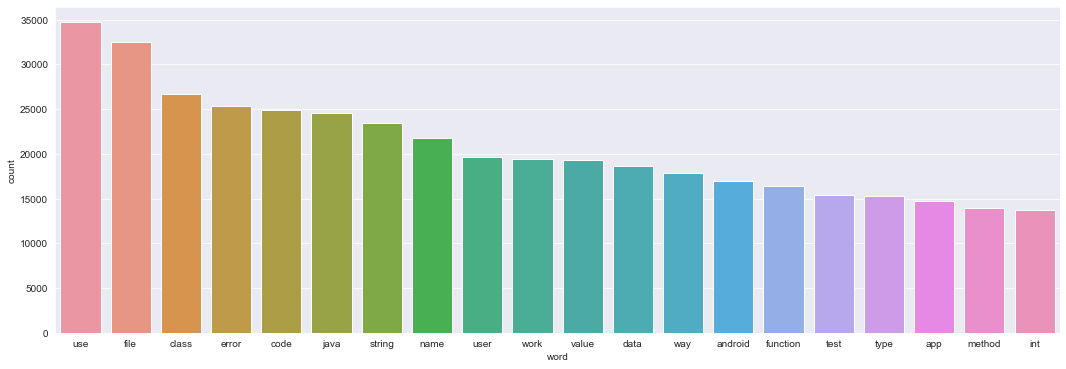

In [210]:
fdist = nltk.FreqDist(corpus_copy)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
# selecting top 20 most frequent words
df1 = words_df.nlargest(columns="count", n=20) 
  
# visualize words and frequencies

plt.figure(figsize=(18,6))
sns.set_style("darkgrid")
sns.barplot(x=df1['word'], y=df1['count'])

**Tracé des mots les plus fréquents dans les Tags**

Nombre de mots de total notre corpus tag : 218910
Nombre de mots unique de notre corpus tag : 14080


<AxesSubplot:xlabel='word', ylabel='count'>

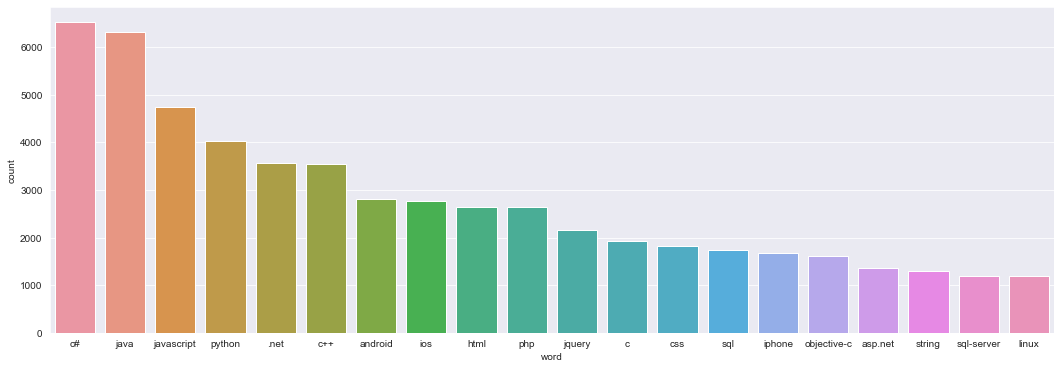

In [222]:
#On contruit le corpus à partir de document_cleaned
corpus_tag =' '.join([text for text in data['Tags']])
corpus_tag_copy = corpus_tag.split()

print("Nombre de mots de total notre corpus tag :", len(corpus_tag_copy))
print("Nombre de mots unique de notre corpus tag :", len(set(corpus_tag_copy)))

fdist = nltk.FreqDist(corpus_tag_copy)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
# selecting top 20 most frequent words
df1 = words_df.nlargest(columns="count", n=20) 
  
# visualize words and frequencies

plt.figure(figsize=(18,6))
sns.set_style("darkgrid")
sns.barplot(x=df1['word'], y=df1['count'])

In [211]:
data.head()

,Title,Body,Tags,Id,document,Body_cleaned,Title_cleaned,document_cleaned
0,Is Java ArrayList / String / atomic variable r...,<p>I've been mulling this over &amp; reading b...,<java><synchronization><multithreading><arrayl...,2388808,Is Java ArrayList / String / atomic variable r...,mull read find absolute authoritative answer s...,java arraylist string atomic variable reading ...,java arraylist string reading thread mull read...
1,GET vs. POST Best Practices,"<p>For my web application (PHP/MYSQL), I show ...",<php><html><http><forms><rest>,679013,GET vs. POST Best Practices <p>For my web appl...,web application php mysql show list item link ...,get post best practice,post practice web application php mysql show l...
2,How to mock a Kotlin singleton object?,<p>Given a Kotlin singleton object and a fun t...,<mocking><mockito><kotlin><powermock><powermoc...,37977320,How to mock a Kotlin singleton object? <p>Give...,give kotlin singleton object fun call method o...,mock kotlin singleton object,kotlin singleton object kotlin singleton objec...
3,Error when dismissing view controller,<p>Getting an error when dismissing a view con...,<ios><objective-c><xcode><uiviewcontroller>,20021107,Error when dismissing view controller <p>Getti...,get error dismiss view controller see anything...,error dismiss view controller,error view controller error view controller in...
4,Google Maps: How to create a custom InfoWindow?,<p>The default Google Maps InfoWindow for a ma...,<javascript><html><css><google-maps>,3860277,Google Maps: How to create a custom InfoWindow...,default google map infowindow map marker round...,google map create custom infowindow,google map custom infowindow default google ma...


In [292]:
from wordcloud import WordCloud
# Regrouping all token to count it
corp_corpus, tags_corpus = [], []
for column in ['document_cleaned', 'Tags']:
    for i in data.index:
        sentence = data[column][i]
        word_tokens = word_tokenize(sentence)
        if column == 'document_cleaned':
            corp_corpus.extend(word_tokens)
        if column == 'Tags':
            tags_corpus.extend(word_tokens)

# Create a list of all tokens for Body
corp_corpus_dist = nltk.FreqDist(corp_corpus)
tags_corpus_dist = nltk.FreqDist(tags_corpus)

# Generate it as pandas table for most frequent word
corp_corpus_dist = pd.DataFrame(corp_corpus_dist.most_common(2000),
                                columns=['Word', 'Frequency'])
tags_corpus_dist = pd.DataFrame(tags_corpus_dist.most_common(2000),
                                columns=['Word', 'Frequency'])

In [293]:
def visualize_most_word(distribution, place):
    """
    It plots most popular word uses in corpus (title or body or corp) feature
    place = title or body or corp
    """
    fig = plt.figure(1, figsize=(16, 12))
    ax = fig.add_subplot(1, 1, 1)
    wordcloud = WordCloud(width=900, height=500,
                           max_words=100, relative_scaling=1,
                          normalize_plurals=False)\
    .generate_from_frequencies(distribution.set_index('Word').to_dict()['Frequency'])
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off") 
    plt.title("Word Cloud of 100 most popular words on {} feature\n".format(str(place)),
              fontsize=24)
    plt.show()

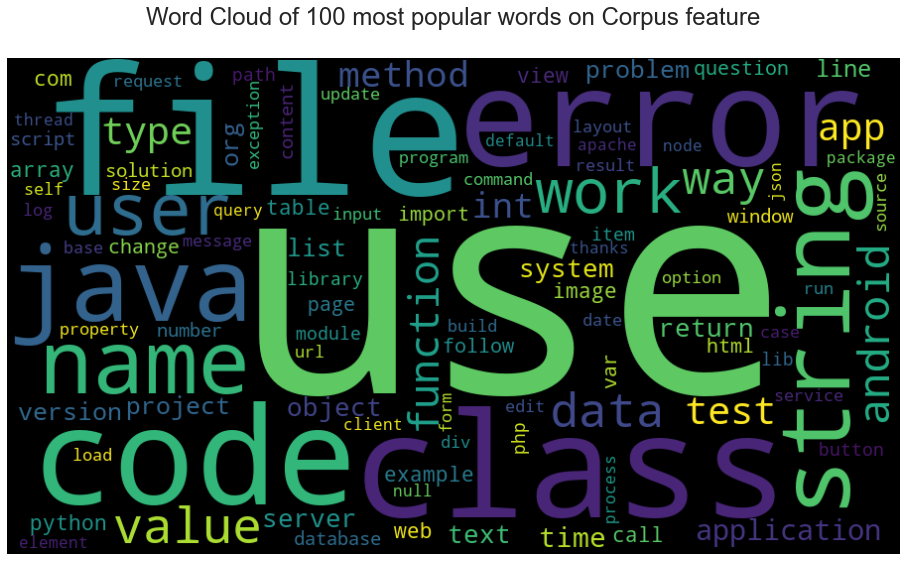

In [294]:
visualize_most_word(corp_corpus_dist, 'Corpus')

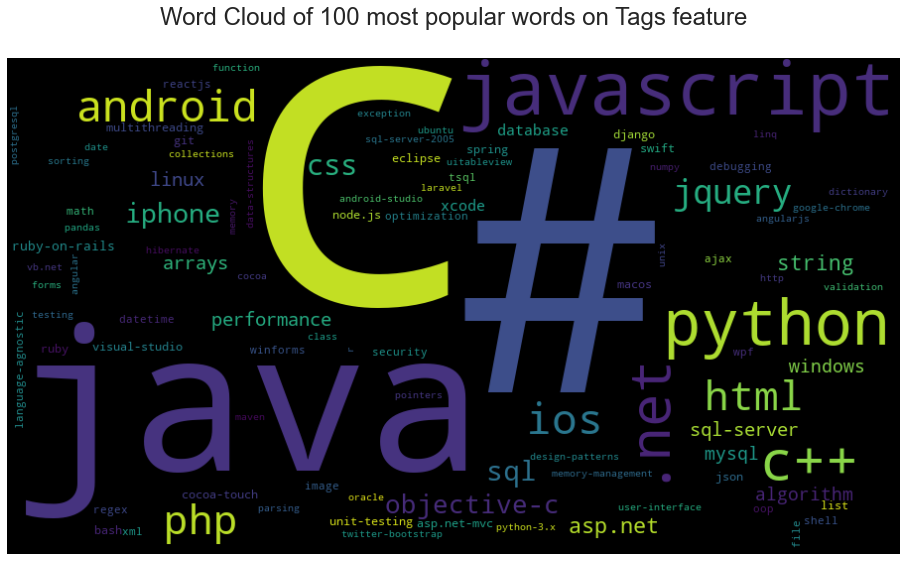

In [295]:
visualize_most_word(tags_corpus_dist , 'Tags')

## <center> ********************************************Mes tests************************************************ </center>

In [212]:
import spacy

txt = "Making make user dad is used and try"
# Create the Language object
nlp1 = spacy.load("en_core_web_sm")
doc = nlp1(txt)
doc

Making make user dad is used and try

In [213]:
print("Base word:", [token.lemma_ for token in doc[1:10]])

Base word: ['make', 'user', 'dad', 'be', 'use', 'and', 'try']


In [214]:
doc = nlp1(data.loc[1, 'document_cleaned'])
type(doc)
type(data.loc[1, 'document_cleaned'])
doc

post practice web application php mysql show list item link row item link href item php action item use post list post data use form item action item php item method post input type name action value input type submit value item form style button look link php curl rest issue

In [215]:
pos_list = ["NOUN","PROPN"]
text_list = []
for token in doc:
        if(token.pos_ in pos_list):
            text_list.append(token.text)
join_text = " ".join(text_list)

join_text

'post practice web application php mysql show list item link row item link href item php action item post list post data form item action item php item method post input type name action value input type submit value item form style button look link php curl rest issue'

In [216]:
# Dans le countvectoriser gérer les mots selon leur fréquence  (max df et min df )

#prochaine étape 
    #méthode d'extraction de features
        # 1.bag of words (tf et count)
        # 2.word/setence embedding (word2vec, bert and use) 



# Approche non supervisée : --> LDA + tfidf 
# Approche supervisée : --> [Regression log, Random forest , sgdclassifier ] x [ word2vec, USE, tfidf, Bert, Countvectorizer ]